In [101]:
import copy
import os
import re
import shutil
import sys
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tifffile
import yaml
from einops import rearrange, repeat
from ome_types import from_xml
from skimage.transform import rescale

Note: the serial sections used in this tutorial have been downsampled for sake of the tutorial to 1-2 sections per data type. In general the more and closer the sections you have the better the reconstruction will be.

Setting run directory

In [2]:
output_dir = Path('../data/registration_example')

Path(output_dir).mkdir(parents=True, exist_ok=True)

Loading in a table that specifies the sections to be registered

section_id - Unique section ID for a section
position - z-position for a section
dtype - Data type of the section. (can be `he`, `xenium`, `multiplex`, `cosmx`, or `visiumhd`)
filepath - Location of the data for the section. The type of file is data dependent. See below.

data types:
- he - tif file
- xenium - 10x output folder
- multiplex - OME-TIF
- visiumhd - 10x output folder




A note about cosmx:

Cosmx can be registered in the same way xenium can, the input files are just in different locations in the flat files folder and require some extra munging.

In [72]:
data_map = pd.read_csv('HT891Z1_sections.txt', sep='\t')
data_map

,section_id,position,dtype,filepath,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 11,Unnamed: 12,Unnamed: 13,Unnamed: 14,Unnamed: 15,Unnamed: 16,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20
0,HT891Z1-U1,0,xenium,/diskmnt/primary/Xenium/data/20240524__182517_...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,HT891Z1-U2,5,he,/diskmnt/primary/Spatial_Transcriptomics/Visiu...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,HT891Z1-U2,5,visiumhd,/diskmnt/primary/Spatial_Transcriptomics/Visiu...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,HT891Z1-U4,10,he,/diskmnt/Users2/estorrs/ding-lab-spatial/data/...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,HT891Z1-U14,65,multiplex,/diskmnt/primary/CODEX/HTAN/20240723_Prostate_...,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [87]:
# setting the section that all other sections will be registered to.
# typically the first section, but doesn't have to be.
target_sid = 'HT891Z1-U1'

## Data loading

Examples and loading functions for the various data types

#### H&E

In [73]:
he_path = data_map[data_map['dtype']=='he']['filepath'].iloc[-1]
he_path

'/diskmnt/Users2/estorrs/ding-lab-spatial/data/registration_example/raw/HT891Z1_U4_he.ome.tif'

reading in the pixel data

In [25]:
x = tifffile.imread(he_path)
x.shape # (h, w, c)

(12315, 13161, 3)

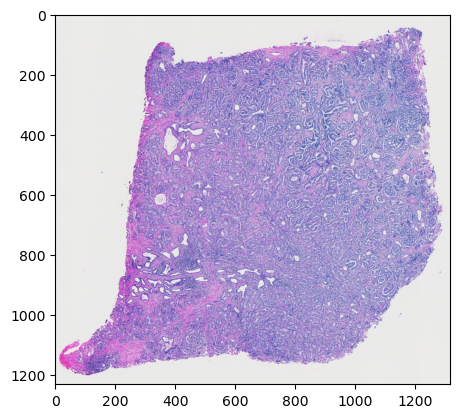

In [28]:
plt.imshow(x[::10, ::10]) # downsampling for faster visualization

#### Multiplex

In [29]:
multiplex_path = data_map[data_map['dtype']=='multiplex']['filepath'].iloc[0]
multiplex_path

'/diskmnt/primary/CODEX/HTAN/20240723_Prostate_serial_HT891Z1-S2H3Fp1_Codex1/HT891Z1-S2H3Fp1_U14__20240723.ome.tiff'

Reading in the file metadata

In [32]:
tf = tifffile.TiffFile(multiplex_path)
model = from_xml(tf.ome_metadata)
pixels = model.images[0].pixels
pixels

Pixels(
   id='Pixels:0',
   channels=[<25 field_type>],
   tiff_data_blocks=[{'plane_count': 25}],
   planes=[<25 field_type>],
   dimension_order='XYCZT',
   type='uint8',
   big_endian=False,
   size_x=13400,
   size_y=12263,
   size_z=1,
   size_c=25,
   size_t=1,
   physical_size_x=0.5100762527233116,
   physical_size_y=0.5100762527233116,
)

In [35]:
channel_order = [c.name for c in pixels.channels]
len(channel_order), channel_order

(25,
 ['DAPI',
  'CK14',
  'LYVE1',
  'CD4',
  'CK5',
  'STEAP4',
  'CD68',
  'E-Cadherin',
  'SMA (D)',
  'CD45(D)',
  'p63',
  'Pan-Cytokeratin',
  'HLA-DR',
  'Podoplanin',
  'Vimentin',
  'CD3e',
  'CD8',
  'CK7',
  'CD44',
  'Foxp3',
  'CD20',
  'Ki67',
  'AR',
  'AMACR',
  'CD31'])

Reading in the pixel level data for specific channels

In [36]:
channels = ['DAPI', 'Pan-Cytokeratin', 'Vimentin']
x = np.stack([
    tf.pages[channel_order.index(c)].asarray() for c in channels
])
x.shape # (c, h, w)

(3, 12263, 13400)

These functions allow us to visualize the multiplex data as pseudocolor images

In [37]:
def hex_to_rgb(
    hex_str: str # hex color
) -> np.ndarray:
    hex_str = hex_str.lstrip("#")
    x = np.asarray([int(hex_str[i:i+2], 16) for i in (0, 2, 4)]).astype(float)
    x /= 255
    return x

def to_pseudocolor(
    data: np.ndarray, # (C, H, W)
    view_settings: dict
) -> np.ndarray:
    """
    Creates an RGB pseudocolor image based on the given image and view settings.
    
    data - (c, h, w)
    view_settings - list of dicts that have the following fields:
        color - hex color for channel
        min_value - min value for channel
        max_value - max value for channel
        gamma - gamma value for channel
    """
    channels = [x['channel'] for x in view_settings]
    rgbs = np.stack([hex_to_rgb(x['color']) for x in view_settings])
    min_values = [x['min_value'] for x in view_settings]
    max_values = [x['max_value'] for x in view_settings]
    gammas = [x['gamma'] for x in view_settings]
        
    scaled = data / np.iinfo(data.dtype).max
    
    min_values = np.asarray(min_values) / np.iinfo(data.dtype).max
    max_values = np.asarray(max_values) / np.iinfo(data.dtype).max
    if gammas is not None:
        gammas = np.asarray(gammas)
        
    for i, val in enumerate(min_values):
        scaled[i][scaled[i] < val] = 0.
    for i, val in enumerate(max_values):
        scaled[i][scaled[i] > val] = val

    scaled -= scaled.min((1, 2), keepdims=True)
    scaled /= scaled.max((1, 2), keepdims=True)

    # gamma
    if gammas is not None:
        scaled **= rearrange(gammas, 'n -> n 1 1')

    scaled += 1e-16

    stacked = repeat(scaled, 'c h w -> c 3 h w ') * rearrange(rgbs, 'c n -> c n 1 1')

    rgb = rearrange(stacked.sum(0), 'c h w -> h w c')
    rgb[rgb>1] = 1.
    
    rgb *= 255.
    rgb = rgb.astype(np.uint8)
    
    return rgb

View settings for each channel contain the following

- channel - name of the channel
- color - hex string of the color to display channel as
- min_value - all pixel intensities below this value will be set to this value, range of the image values is usually 0-255
- max_value - all pixel intensities above this value will be set to this value, range of the image values is usually 0-255
- gamma - gamma contrast value

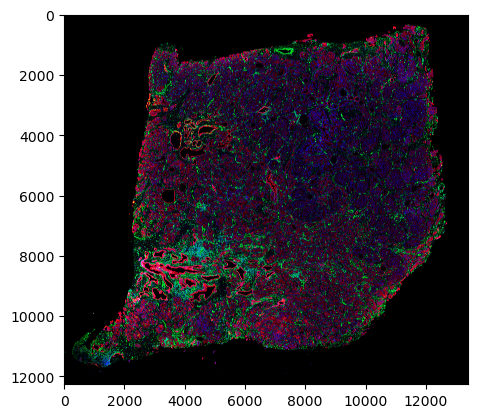

In [42]:
view_settings = [
    {
        'channel': 'DAPI',
        'color': '#0000ff',
        'min_value': 0,
        'max_value': 255,
        'gamma': 1.
    },
    {
        'channel': 'Pan-Cytokeratin',
        'color': '#ff0000',
        'min_value': 0,
        'max_value': 150,
        'gamma': 1.
    },
    {
        'channel': 'Vimentin',
        'color': '#00ff00',
        'min_value': 0,
        'max_value': 150,
        'gamma': 1.
    },
]

rgb = to_pseudocolor(x, view_settings)
plt.imshow(rgb)

#### xenium

Note: cosmx is essentially the same underlying data, just formatted differently. If you want to see examples of loading cosmx please see [this notebook](https://github.com/estorrs/3d-analysis/blob/main/notebooks/1_cosmx_preprocessing.ipynb) and [this notebook](https://github.com/ding-lab/mushroom/blob/main/notebooks/manuscript/submission_v1/cosmx_processing.ipynb)

In [48]:
# this is the spaceranger outs directory
xenium_path = Path(data_map[data_map['dtype']=='xenium']['filepath'].iloc[0])
assert xenium_path.is_dir()
xenium_path

PosixPath('/diskmnt/primary/Xenium/data/20240524__182517__20240524_HTAN_prostate_serial/output-XETG00122__0034184__HT891Z1-S2H3Fp1U1__20240524__182554')

In [62]:
def get_xenium_morphology_path(directory):
    """
    Will try to find xenium morphology image, as the file name changes across xenium versions
    """
    if (directory / 'morphology_focus.ome.tif').is_file():
        path = directory / 'morphology_focus.ome.tif'
    elif (directory / 'morphology_focus').is_dir():
        path = directory / 'morphology_focus' / 'morphology_focus_0000.ome.tif'
    else:
        raise RuntimeError(f'Could not find morphology.ome.tif')

    return path

def to_uint8(x):
    """
    Convienence function for converting image to uint8
    """
    x = x.astype(np.float32)
    x /= x.max()
    x *= 255
    x = x.astype(np.uint8)
    return x

In [50]:
# grabbing the xenium morphology image
morphology_path = get_xenium_morphology_path(xenium_path)
assert morphology_path.is_file()

In [51]:
# if earlier version of xenium it may just be dapi, if newer version it could be a multichannel tif
tf = tifffile.TiffFile(morphology_path)
model = from_xml(tf.ome_metadata)
pixels = model.images[0].pixels
pixels

Pixels(
   id='Pixels:0',
   channels=[<4 field_type>],
   tiff_data_blocks=[<4 field_type>],
   dimension_order='XYZCT',
   type='uint16',
   size_x=34166,
   size_y=30732,
   size_z=1,
   size_c=4,
   size_t=1,
   physical_size_x=0.2125,
   physical_size_y=0.2125,
)

In [64]:
channel_order = [c.name for c in pixels.channels]
x = tf.asarray() # (c, h, w) or (h, w)

# add a channel dimension if we don't already have it
if len(x.shape) == 2:
    x = x[None, ...]

# convert to uint8 to save space if we haven't already
if x.dtype != np.uint8:
    x = to_uint8(x)

x.shape, channel_order

((4, 30732, 34166),
 ['DAPI', 'ATP1A1/CD45/E-Cadherin', '18S', 'alphaSMA/Vimentin'])

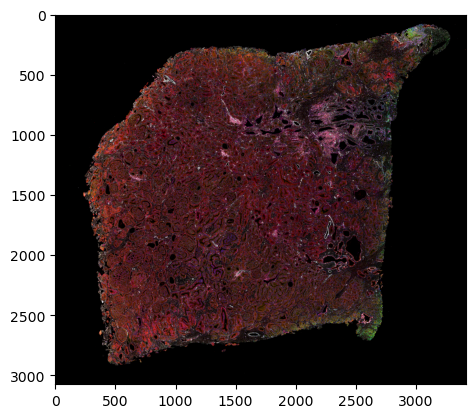

In [67]:
# these view settings might change depending on what version of xenium you are dealing with (i.e. just one dapi channel instead of 4 channels
view_settings = [
    {
        'channel': 'DAPI',
        'color': '#0000ff',
        'min_value': 0,
        'max_value': 255,
        'gamma': 1.
    },
    {
        'channel': 'ATP1A1/CD45/E-Cadherin',
        'color': '#ff0000',
        'min_value': 0,
        'max_value': 150,
        'gamma': 1.
    },
    {
        'channel': '18S',
        'color': '#00ff00',
        'min_value': 0,
        'max_value': 100,
        'gamma': 1.
    },
    {
        'channel': 'alphaSMA/Vimentin',
        'color': '#ffffff',
        'min_value': 0,
        'max_value': 100,
        'gamma': 1.
    },
]
# downsampling the image to save some time here
rgb = to_pseudocolor(x[..., ::10, ::10], view_settings)
plt.imshow(rgb)

#### Visium HD

In [75]:
# this is the he for the visiumhd, it is what we will use for the registration of the visiumhd
he_path = Path(data_map[data_map['dtype']=='he']['filepath'].iloc[0])
assert he_path.is_file()
he_path

PosixPath('/diskmnt/primary/Spatial_Transcriptomics/VisiumHD_run/Image/20240715_HTAN_prostate serial/HT891Z1-S2H3Fp1U2_Scan2.qptiff')

In [76]:
x = tifffile.imread(he_path)
x.shape # (h, w, c)

(17280, 15360, 3)

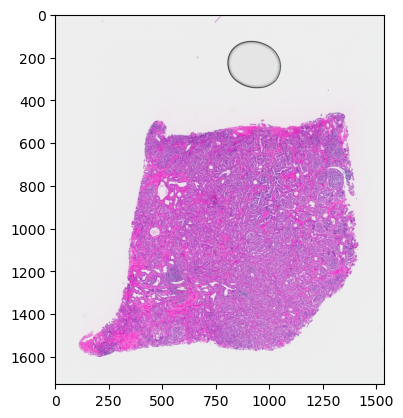

In [77]:
plt.imshow(x[::10, ::10]) # downsampling for faster visualization

## Saving images for registration with BigWarp

The data is currently unregistered, we need to register them.

To do so we will use [BigWarp](https://imagej.net/plugins/bigwarp).

First, we need to save an unregistered image for each section. That image will be aligned with bigwarp, and we can use the resulting transformation matrix to transform the data for the section.

In [81]:
# view settings for multiplex images
multiplex_view_settings = [
    {
        'channel': 'DAPI',
        'color': '#0000ff',
        'min_value': 0,
        'max_value': 255,
        'gamma': 1.
    },
    {
        'channel': 'Pan-Cytokeratin',
        'color': '#ff0000',
        'min_value': 0,
        'max_value': 150,
        'gamma': 1.
    },
    {
        'channel': 'Vimentin',
        'color': '#00ff00',
        'min_value': 0,
        'max_value': 150,
        'gamma': 1.
    },
]

xenium_view_settings = [
    {
        'channel': 'DAPI',
        'color': '#0000ff',
        'min_value': 0,
        'max_value': 255,
        'gamma': 1.
    },
    {
        'channel': 'ATP1A1/CD45/E-Cadherin',
        'color': '#ff0000',
        'min_value': 0,
        'max_value': 150,
        'gamma': 1.
    },
    {
        'channel': '18S',
        'color': '#00ff00',
        'min_value': 0,
        'max_value': 100,
        'gamma': 1.
    },
    {
        'channel': 'alphaSMA/Vimentin',
        'color': '#ffffff',
        'min_value': 0,
        'max_value': 100,
        'gamma': 1.
    },
]

In [78]:
# this is the scale factor that will be used for registration
# meaning all images will be downsampled by this much
# this helps speed up the registration process because bigwarp will be very slow if you try to run it on full size images
scale_factor = 10

In [79]:
# where we will write the unregistered images
unregistered_dir = output_dir / 'unregistered'
unregistered_dir.mkdir(parents=True, exist_ok=True)

In [83]:
# we ignore visiumhd data type because we have a matching H&E we will use for registration
# if you have a visiumhd sample make sure that it has a matching H&E with the same section id
filtered = data_map[data_map['dtype'] != 'visiumhd']

# iterating through the sections and saving a downsampled RGB image that will be used for registration with bigwarp
for i, row in filtered.iterrows():
    section_id, position, dtype = row['section_id'], row['position'], row['dtype']
    path = Path(row['filepath'])
    print(section_id, dtype)

    if dtype == 'he':
        rgb = tifffile.imread(path)
        assert rgb.shape[2] == 3, f'Must be a 3 channel RGB, got {x.shape}'

        rgb = rgb[::scale_factor, ::scale_factor]
    elif dtype == 'multiplex':
        tf = tifffile.TiffFile(path)
        model = from_xml(tf.ome_metadata)
        pixels = model.images[0].pixels
        channel_order = [c.name for c in pixels.channels]
        
        channels = [entry['channel'] for entry in multiplex_view_settings]
        x = np.stack([
            tf.pages[channel_order.index(c)].asarray() for c in channels
        ])
        rgb = to_pseudocolor(x[..., ::scale_factor, ::scale_factor], multiplex_view_settings)   
    elif dtype == 'xenium':
        morphology_path = get_xenium_morphology_path(path)
        tf = tifffile.TiffFile(morphology_path)
        model = from_xml(tf.ome_metadata)
        pixels = model.images[0].pixels
        channel_order = [c.name for c in pixels.channels]
        
        x = tf.asarray() # (c, h, w) or (h, w)
        
        # add a channel dimension if we don't already have it
        if len(x.shape) == 2:
            x = x[None, ...]

        # downsample
        x = x[..., ::scale_factor, ::scale_factor]
        
        # convert to uint8 to save space if we haven't already
        if x.dtype != np.uint8:
            x = to_uint8(x)

        rgb = to_pseudocolor(x, xenium_view_settings)
    else:
        raise RuntimeError(f'Unknown data type: {dtype}')

    # save image
    tifffile.imwrite(unregistered_dir / f'Z{position}_{section_id}_{dtype}.tif', rgb, compression='LZW')

<tifffile.TiffFile 'morphology_focus_0000.ome.tif'> OME series cannot read multi-file pyramids


HT891Z1-U1 xenium
HT891Z1-U2 he
HT891Z1-U4 he
HT891Z1-U14 multiplex


In [86]:
# the resulting files can now be registered with bigwarp
list(unregistered_dir.rglob('*.tif'))

[PosixPath('../data/registration_example/unregistered/Z10_HT891Z1-U4_he.tif'),
 PosixPath('../data/registration_example/unregistered/Z0_HT891Z1-U1_xenium.tif'),
 PosixPath('../data/registration_example/unregistered/Z65_HT891Z1-U14_multiplex.tif'),
 PosixPath('../data/registration_example/unregistered/Z5_HT891Z1-U2_he.tif')]

## BigWarp registration

You will need to install Fiji/ImageJ.

See [here](https://zenodo.org/records/12611046) for a video with voice over that tells you how to register images with bigwarp. Additionally, I have [this video](https://wustl.box.com/s/yuk4goulfsp5eqj64n070w56epmgokkx) with no audio that shows me registering the samples for this demo.

In short, we need to export a warp field (*ddf.tif) from BigWarp for each section. These warp fields are then used in the next section to register full resolution data for each section

## Registration of data

After bigwarp registration, we should have a ddf warp field for each section we registered. (in this case we used HT891Z1-U1 as the target section, so it does not need to be registered as everything else is being registered to it)

In [88]:
ddf_paths = list(unregistered_dir.rglob('*ddf.tif'))
ddf_paths

[PosixPath('../data/registration_example/unregistered/Z5_HT891Z1-U2_he_ddf.tif'),
 PosixPath('../data/registration_example/unregistered/Z65_HT891Z1-U14_multiplex_ddf.tif'),
 PosixPath('../data/registration_example/unregistered/Z10_HT891Z1-U4_he_ddf.tif')]

In [92]:
# mapping section ID to it's DDF
sid_to_ddf = {
    re.sub(r'Z[0-9]+_(.*)_[a-z]+_ddf.tif$', r'\1', path.name):path for path in ddf_paths
}
sid_to_ddf

{'HT891Z1-U2': PosixPath('../data/registration_example/unregistered/Z5_HT891Z1-U2_he_ddf.tif'),
 'HT891Z1-U14': PosixPath('../data/registration_example/unregistered/Z65_HT891Z1-U14_multiplex_ddf.tif'),
 'HT891Z1-U4': PosixPath('../data/registration_example/unregistered/Z10_HT891Z1-U4_he_ddf.tif')}

#### Exploring the DDF file

In [98]:
# grab one of the DDFs
ddf_path = next(iter(sid_to_ddf.values()))
ddf = tifffile.imread(ddf_path)
ddf.shape

(3, 3074, 3417)

BigWarp saves the DDF as (axes, h, w) where h and w are the image width and height, while axes are the x, y, and z axes respectively.

We grab the x and y axes

In [102]:
ddf_x, ddf_y = ddf[0], ddf[1]
ddf_x.shape, ddf_y.shape

((3074, 3417), (3074, 3417))

Lets take a look

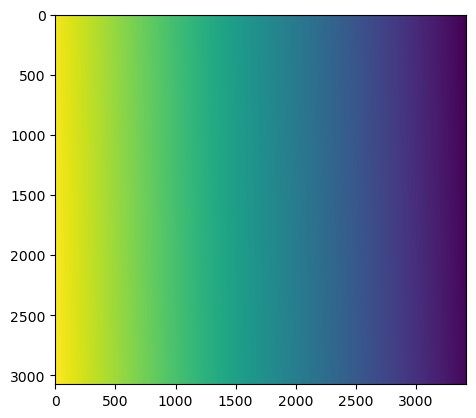

In [103]:
plt.imshow(ddf_x)

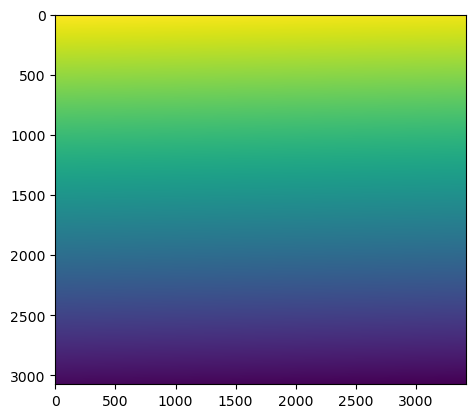

In [104]:
plt.imshow(ddf_y)

Each pixel of the DDF is a mapping that maps a pixel from the unregistered image to its new, registered position

In [108]:
# so here, for example, the registered pixel at (0, 0) will now have the value of the unregistered pixel at (1473, 1726)
ddf_x[0, 0], ddf_y[0, 0]

(np.float32(1473.0908), np.float32(1726.1704))

Crucially, since we downsampled the unregistered images so bigwarp would run faster, we need to rescale the bigwarp DDF to match the full res data

In [112]:
ddf_small = np.stack((ddf_y, ddf_x)) # we're ordering the axes as y, x so the shape will be (c, h, w)
ddf_scaled = rescale(ddf_small, scale=scale_factor, preserve_range=True, anti_aliasing=False, channel_axis=0)
ddf_scaled.shape

(2, 30740, 34170)

Important note: The resolution of the DDF will be equal to the resolution of the target section (HT891Z1_U1 in this case)

Once we have the full-res DDF we can use it to scale the data for the corresponding section. We show examples of that below for different data types

Collating the above into a function here so we can use in the data type specific sections

In [113]:
def get_ddf_for_section(section_id):
    """
    Returns DDF for the given section.
    """
    ddf = sid_to_ddf[section_id]
    ddf = tifffile.imread(ddf)
    ddf = ddf[[1, 0]] # taking y and x axes in that order
    ddf = rescale(ddf, scale=scale_factor, preserve_range=True, anti_aliasing=False, channel_axis=0) # rescale to full size
    return ddf

#### Registering H&E

In [96]:
# the H&E section
# note that this is actually the H&E for the visiumhd, I'll cover how to register visiumhd in one of the following sections,
# but I also want to just have an H&E registration section
section_id = 'HT891Z1-U2'

mask = (
    (data_map['section_id'] == section_id) &\
    (data_map['dtype'] == 'he')
)
row = data_map[mask].iloc[0]

position, filepath = row['position'], Path(row['filepath'])

filepath

PosixPath('/diskmnt/primary/Spatial_Transcriptomics/VisiumHD_run/Image/20240715_HTAN_prostate serial/HT891Z1-S2H3Fp1U2_Scan2.qptiff')

reading in the unregistered image

In [97]:
unregistered_x = tifffile.imread(filepath)
unregistered_x.shape

(17280, 15360, 3)

In [ ]:
def read_bigwarp_warp_field(fp, downsample_scaler):
    """
    Read bigwarp DDF warp field.
    """
    ddf = torch.tensor(tifffile.imread(fp))
    ddf = ddf[[1, 0]] # needs to be (h, w, c), bigwarp exports (w, h, c)

    # rescale to original size
    scale = 1 / downsample_scaler

    ddf = TF.resize(ddf, (int(ddf.shape[-2] * scale), int(ddf.shape[-1] * scale)), antialias=False)
    ddf *= scale

    return ddf